# **Pokemon Classifier - Gen 1**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

In [ ]:
%matplotlib inline

## **Data Collection And Processing**

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((250, 250)),
        transforms.ToTensor(),

        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ]
)

In [ ]:
data = datasets.ImageFolder(
    "/content/PokemonData",
    transform = transform
)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    data,
    train_size = 0.85,
    random_state = 71
)

In [ ]:
print(len(train_data))
print(len(test_data))

5797
1023


In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size = 10,
    shuffle = True
)

test_loader = DataLoader(
    test_data,
    batch_size = 10,
    shuffle = True
)

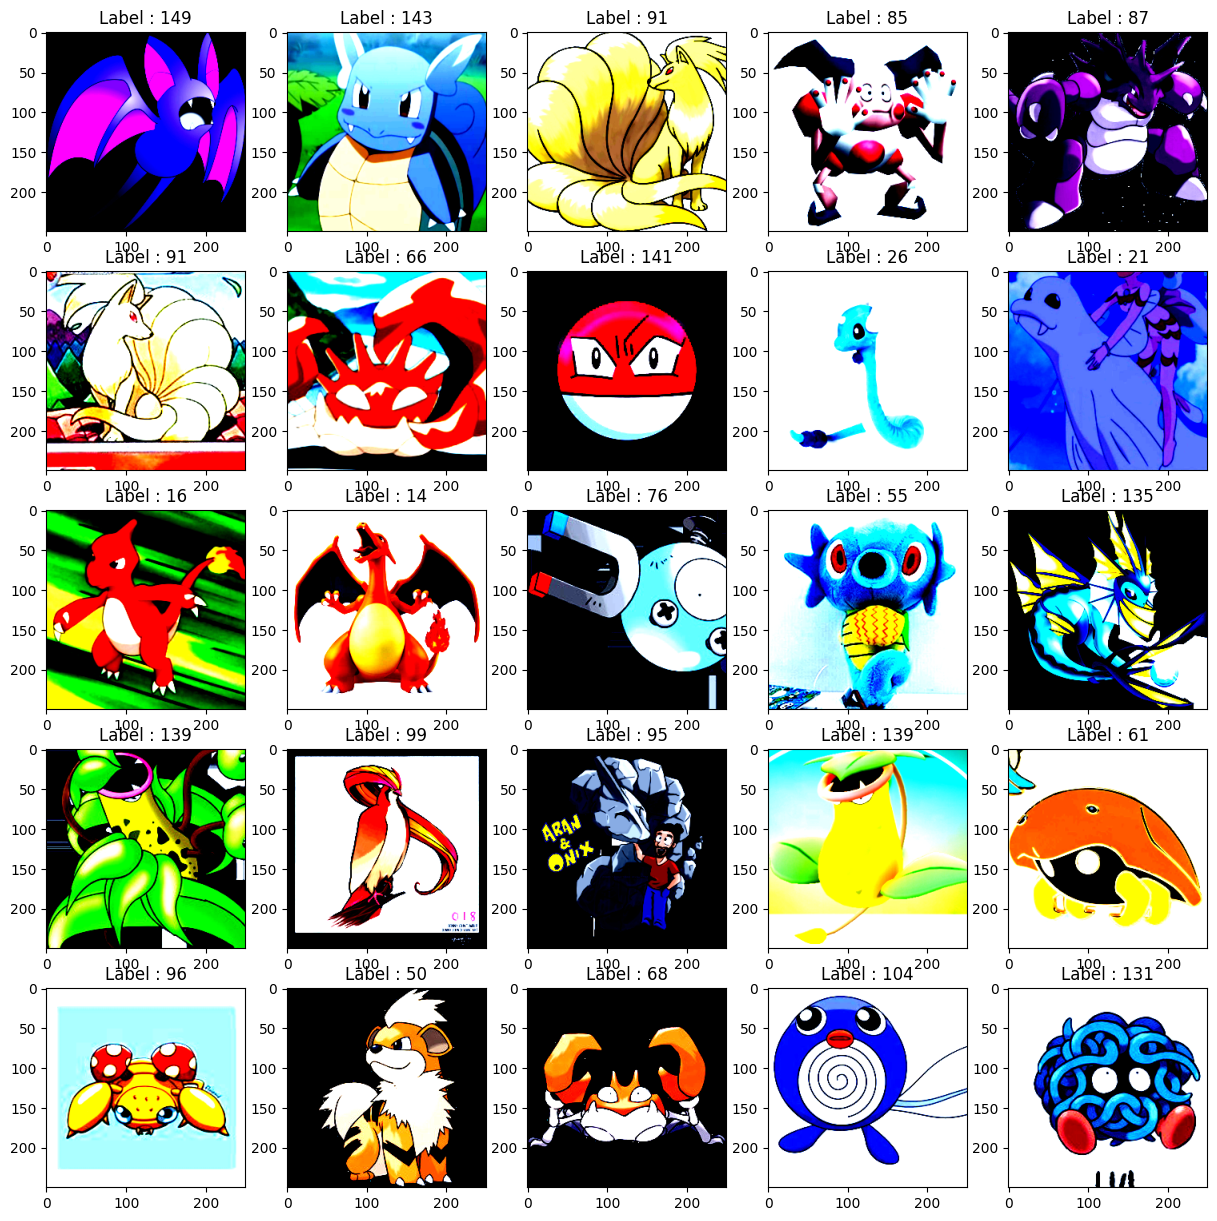

In [ ]:
from random import randint

fig = plt.figure(figsize = (15, 15))

for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    random_num = randint(0, 5000)

    plt.imshow(
        train_loader.dataset[random_num][0].detach().numpy().transpose((1, 2, 0))
    )

    plt.title(f"Label : {train_loader.dataset[random_num][1]}")

## **Deep Learning**

### **Initialising ResNet 18**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
Model = models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.8MB/s]


In [ ]:
Model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for p in Model.parameters():
  p.requires_grad = False

In [ ]:
Model.fc = nn.Linear(512, 150)

In [ ]:
Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **Training The Model**

In [ ]:
criterion = nn.CrossEntropyLoss()# Loss Function
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001)# Optimizer

In [ ]:
import time

start_time = time.time()

epochs : int = 25
train_losses : int = []
test_losses : int = []
train_correct : int = []
test_correct : int = []

train_corr = 0
test_corr = 0

i : int = 1
while i <= epochs:
  train_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1

    y_pred = Model(X_train.to(device))
    loss = criterion(y_pred, y_train.to(device))
    predicted = torch.max(y_pred.data, 1)[1]

    batch_corr : int = (predicted == y_train.to(device)).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b + 1) % 500 == 0:
      print(f"Epoch : {i}, Loss : {loss.item()}, Accuracy : {test_corr / len(test_data)}")

  train_losses.append(loss)
  train_correct.append(train_corr)

  test_corr = 0

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = Model(X_test.to(device))
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test.to(device)).sum()

  loss = criterion(y_val, y_test.to(device))
  test_losses.append(loss)
  test_correct.append(test_corr)

  i += 1

current_time = time.time()
print(f"Time taken to train the model : {current_time - start_time} seconds")

Epoch : 1, Loss : 2.957045555114746, Accuracy : 0.0
Epoch : 2, Loss : 1.7267439365386963, Accuracy : 0.5141739845275879
Epoch : 3, Loss : 0.7890912890434265, Accuracy : 0.6881720423698425
Epoch : 4, Loss : 1.067530870437622, Accuracy : 0.7096773982048035
Epoch : 5, Loss : 1.0068532228469849, Accuracy : 0.7272727489471436
Epoch : 6, Loss : 0.2708500027656555, Accuracy : 0.7526881694793701
Epoch : 7, Loss : 0.42422255873680115, Accuracy : 0.7575757503509521
Epoch : 8, Loss : 0.2397686243057251, Accuracy : 0.7575757503509521
Epoch : 9, Loss : 0.06388179212808609, Accuracy : 0.759530782699585
Epoch : 10, Loss : 0.5203052759170532, Accuracy : 0.759530782699585
Epoch : 11, Loss : 0.21460413932800293, Accuracy : 0.7859237790107727
Epoch : 12, Loss : 0.2222374677658081, Accuracy : 0.7585532665252686
Epoch : 13, Loss : 0.33425432443618774, Accuracy : 0.7634408473968506
Epoch : 14, Loss : 0.16664084792137146, Accuracy : 0.738025426864624
Epoch : 15, Loss : 0.3232001066207886, Accuracy : 0.739002

### **Testing The Model And Plotting The Results**

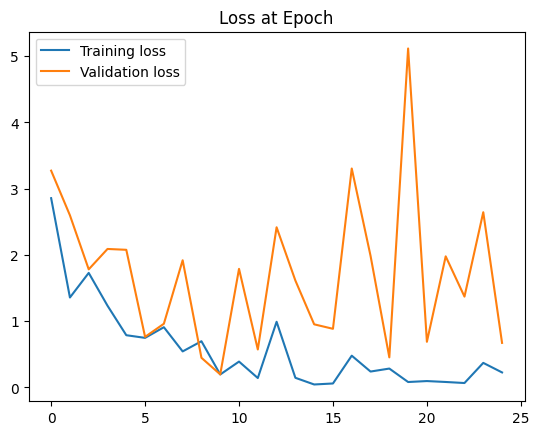

In [ ]:
# plotting the results

train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]

plt.plot(np.array(train_losses), label = "Training loss")
plt.plot(np.array(test_losses), label = "Validation loss")
plt.title("Loss at Epoch")
plt.legend()

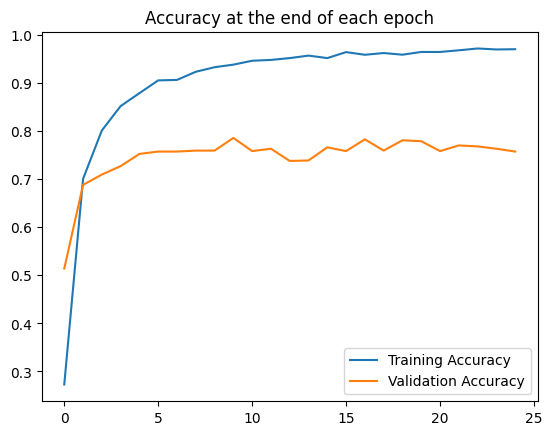

In [ ]:
# plotting the results

train_correct = [tl.item() for tl in train_correct]
test_correct = [tl.item() for tl in test_correct]

plt.plot([t / len(train_data) for t in train_correct], label = "Training Accuracy")
plt.plot([t / len(test_data) for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_pred = Model(X_test.to(device))
    predicted = torch.max(y_pred, 1)[1]
    correct += (predicted == y_test.to(device)).sum()

In [ ]:
# Accuracy
print(f"Length Of Data : {len(test_data)}\nCorrect : {correct.item()}\nAccuracy : {correct.item() / len(test_data) * 100}%")

Length Of Data : 1023
Correct : 791
Accuracy : 77.32160312805473%


In [ ]:
Model.eval()
fig = plt.figure(figsize = (120, 120))

for i in range(10):
    fig.add_subplot(5, 2, i + 1)
    plt.imshow(test_loader.dataset[i][0].detach().numpy().transpose(1, 2, 0))

    with torch.no_grad():
        y_pred = Model(test_loader.dataset[i][0].unsqueeze(0).to(device))
        y_pred_text = "Actual Value : " + [
            j for j in data.class_to_idx if (data.class_to_idx[j]) == (test_loader.dataset[i][1])
        ][0] + "\nPredicted : " + [
            j for j in data.class_to_idx if data.class_to_idx[j] == torch.max(y_pred, 1)[1][0]
        ][0]

    plt.title(y_pred_text, fontdict = {"fontsize" : 100})

### **Saving The Model**

In [ ]:
torch.save(Model.state_dict(), "PokemonClassifier_CNN_Model.pt")